In [ ]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
import nltk
import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving reviews.csv to reviews.csv


In [ ]:
df = pd.read_csv('reviews.csv', encoding='utf-8')
df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,2060,158,2008-09-22,2865,Thom,"very nice neighborhood,close enough to ""A"" tra..."
1,2595,17857,2009-11-21,50679,Jean,Notre séjour de trois nuits.\r\nNous avons app...
2,2595,19176,2009-12-05,53267,Cate,Great experience.
3,2595,19760,2009-12-10,38960,Anita,I've stayed with my friend at the Midtown Cast...
4,2595,34320,2010-04-09,71130,Kai-Uwe,"We've been staying here for about 9 nights, en..."


In [ ]:
df.info

<bound method DataFrame.info of          listing_id  ...                                           comments
0              2060  ...  very nice neighborhood,close enough to "A" tra...
1              2595  ...  Notre séjour de trois nuits.\r\nNous avons app...
2              2595  ...                                  Great experience.
3              2595  ...  I've stayed with my friend at the Midtown Cast...
4              2595  ...  We've been staying here for about 9 nights, en...
...             ...  ...                                                ...
1273971    42794256  ...  Great place that hit the mark for my night in ...
1273972    42816035  ...  This duplex home is a real gem in New York Cit...
1273973    42836326  ...  I loved the location, very bright apartment wa...
1273974    42855403  ...  The host canceled this reservation 8 days befo...
1273975    42889839  ...  The host canceled this reservation 7 days befo...

[1273976 rows x 6 columns]>

In [ ]:
df.isna().sum()

listing_id         0
id                 0
date               0
reviewer_id        0
reviewer_name     10
comments         749
dtype: int64

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

listing_id       0
id               0
date             0
reviewer_id      0
reviewer_name    0
comments         0
dtype: int64

In [ ]:
df = df.reset_index()

In [ ]:
df['index'] = df.index

In [ ]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['comments'])

In [ ]:
#Clean text without lemmatization
nlp = spacy.load('en', disable=['ner', 'parser'])
def cleaning(doc):
    txt = [token.text for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
#Clean text with lemmatization
nlp = spacy.load('en', disable=['ner', 'parser'])
def cleaning_lem(doc):
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

In [ ]:
t = time()

txt = [cleaning_lem(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 33.55 mins


In [ ]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
print(df_clean.shape)
print('\n')
print(df_clean.head())

(1172222, 1)


                                               clean
0  stay night enjoy center city sleep short way m...
1  wonderful stay jennifer charming apartment org...
2  hi great compliment jennifer host midtown cast...
3  jennifer friendly helpful place exactly advert...
4  apartment like real castle old unique age rela...


In [ ]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser

In [ ]:
sent = [row.split() for row in df_clean['clean']]

In [ ]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

In [ ]:
bigram = Phraser(phrases)

INFO - 18:28:48: source_vocab length 4405876
INFO - 18:29:36: Phraser built with 12627 phrasegrams


In [ ]:
sentences = bigram[sent]

In [ ]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

193393

In [ ]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['stay',
 'place',
 'great',
 'apartment',
 'clean',
 'host',
 'location',
 'nice',
 'good',
 'room']

In [ ]:
import multiprocessing

from gensim.models import Word2Vec

In [ ]:
cores = multiprocessing.cpu_count()
cores

2

In [ ]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [ ]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
w2v_model.init_sims(replace=True)

INFO - 20:05:04: precomputing L2-norms of word weight vectors


In [ ]:
w2v_model.wv.most_similar(positive=["owner"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('landlord', 0.6724129915237427),
 ('host', 0.6176611185073853),
 ('guest', 0.6152698397636414),
 ('ask', 0.5772091746330261),
 ('tenant', 0.5688183307647705),
 ('person', 0.5656557679176331),
 ('tell', 0.5654337406158447),
 ('responsible', 0.5632977485656738),
 ('clearly', 0.5609010457992554),
 ('issue', 0.531084418296814)]

In [ ]:
w2v_model.wv.most_similar(positive=["renter"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('guest', 0.659747838973999),
 ('tenant', 0.6238182187080383),
 ('rent', 0.5575793981552124),
 ('owner', 0.5208114385604858),
 ('rental', 0.4875015914440155),
 ('lodger', 0.4805244207382202),
 ('airbnber', 0.47886523604393005),
 ('share', 0.4779818058013916),
 ('occupant', 0.47574204206466675),
 ('customer', 0.47498005628585815)]

In [ ]:
w2v_model.wv.most_similar("customer")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('guest', 0.593864381313324),
 ('customer_service', 0.5020461082458496),
 ('renter', 0.4749799966812134),
 ('tell', 0.46826279163360596),
 ('client', 0.4682227671146393),
 ('rent', 0.4661989212036133),
 ('airbnb', 0.46274036169052124),
 ('owner', 0.46236157417297363),
 ('know', 0.4540901184082031),
 ('trust', 0.45090940594673157)]

In [ ]:
w2v_model.wv.similarity("customer", 'guest')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.5938644

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


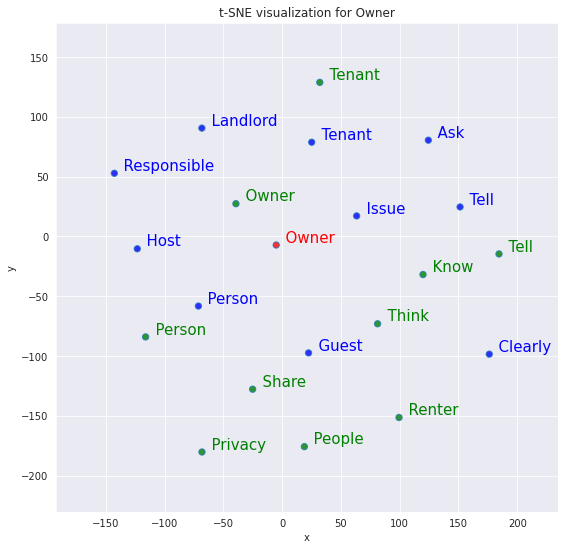

In [ ]:
tsnescatterplot(w2v_model, 'owner', [i[0] for i in w2v_model.wv.most_similar(positive=['guest'])])